<h1> Implementing a Multilayer Perceptron Network from Scratch </h1>
<b> By David Jiménez Barrero </b>

In this notebook, I go step-by-step over my implementation of an MLP from scratch.
1. I detail the implementation
2. <b> Part A: </b> Train it without regularization
3. <b> Part B: </b> Train it with regularization
4. <b> Part C: </b> Train it with dropout-regularization
5. <b> Part D: </b> Compare the results with a Tensorflow MLP

(Please run the following two lines which are a few setup lines for the Jupyter notebook to run correctly)

In [2]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
#Library for displaying widgets
from ipywidgets import widgets
from IPython.core.display import HTML
from IPython.display import Latex

<h2> Notes on backpropagation: </h2>
(This section explains the resoning behind backpropagation adjusted to this particular problem, however it can be skipped)

In [114]:
%%latex 
I implemented a MLP consisting of 1 input layer, 2 hidden layers and 1 output layer. The activation funtion for the two hidden layers is a Softmax activation function described as:
\begin{align}
\hat{y_i}(s_i) = \frac{e^{s_i}}{\sum^{N_c}_c e^{s_c}},
\end{align}
where
\begin{align}
s_i = \sum_j W_{i,j}x_j,
\end{align}

and $\mathbf{W}$ is the interconnection weights matrix and $\mathbf{x}$ is the vector of nodes on a layer.

Now, for the loss function, it was required to used cross-entropy, described as:

\begin{align}
E = - \sum_c O_{c,i} \log \hat{y_i},
\end{align}

where $c \in \{Classes\}$, $\hat{y_c}$ is the predicted class, and $O_{c,i}$ is a function of binary range which is $1$ when $c = i$ and $0$ otherwise. I will call $O_{c,i} = y$ as it represents the $true$ output.

Now, a few notes on backpropagation. In backpropagation the weights of the network are updated in order to minimize the error, which is calculated using the cross-entropy loss, it is done using gradient descent (more advanced methods such as Conjugate Gradients, or  Levenberg–Marquardt produce faster and better results). Then, for the last layer $L$ we want:
    
\begin{align}
W_{i,j}^L := W_{i,j}^L + \sigma \frac{\partial E}{\partial W_{i,j}},
\end{align}

where $\sigma$ is the learning rate, and
\begin{align}
\frac{\partial E}{\partial W_{i,j}} = \frac{\partial E}{\partial \hat{y_i}} \frac{\partial \hat{y_i}}{\partial s_i} \frac{\partial s_i}{\partial W_{i,j}} = (\hat{y_i}-y_i)h_j^{L-1}
\end{align}

I call $(\hat{y_i}-y_i) = \delta^L$.

Thus, I know how to update $W$ in the last layer assuming that the input to that layer from the previous layer $h_j^{L-1}$ is right. As this is not true, I intend to find how much I must update this layer $h_j^{L-1}$, i.e.: $\Delta h_j^{L-1}$. This is done using gradient descent again but using the change of the error respect to $h_j^{L-1}$.

\begin{align}
\Delta h_j^{L-1} = \frac{\partial E}{\partial h_j^{L-1}} = \sum_i (\hat{y_i} - y_i) W_{i,j} = \sum_i \delta^L W_{i,j},
\end{align}

Notice $\delta^L$ appeared again in this equation. Now I now what the change for $h_j^{L-1}$ should be, however I cannot update $h_j^{L-1}$ directly, but I can only update the weights in the previous layer. Nevertheless, I know the magnitude of change which is $\Delta h_j^{L-1}$. I update in the direction of maximum change which is the derivative and I obtain the equation:
    
\begin{align}
W_{i,j}^{L-1} := W_{i,j}^{L-1} - \sigma \Delta h_j^{L-1} \tanh ' (h_j^{L-2}) = W_{i,j}^{L-1} - \sigma \Delta h_j^{L-1} (1 - \tanh^2 (h_j^{L-2}))h_j^{L-2}.
\end{align}

Now, I call $\Delta h_j^{L-1} (1 - \tanh^2 (h_j^{L-2})) = \delta^{L - 1}$ to follow the pattern on the L level. And this is it - I have created a recursion rule to update all the weights.


<IPython.core.display.Latex object>

<h2> Network </h2>
In this section I define the class MLP which is my Multilayer Perceptron Network. As it is a class, I cannot individually explain every segment of code in Jupyter Notebook, however I commented the code. Note that on this same class I have implemented methods for both L2 regularization as well as Dropout regularization. I will go into more detail later.

In [53]:
import numpy as np

def tanh(x):
    ''' Tanh activation function '''
    return np.tanh(x)

def dtanh(x):
    ''' Derivative of tanh activation function '''
    return [ 1.0 - xt**2 for xt in x ]

def softmax(x):
    ''' Softmax activation function '''
    e = [ np.exp(float(xt)) for xt in x] 
    return (e/np.sum(e))

def cross_entropy_error(y,yhat):
    ''' Cross_entropy activation function '''
    return -np.dot( y , [ np.log(i) for i in yhat ] )
     

class MLP:
    ''' Multi-layer perceptron class '''
    # Note that the bias on each layer IS present, even if it is not explicitly stated.

    def __init__(self, *args):
        ''' Initialization of the perceptron with given sizes.  '''
        
        # The arguments define the amount of layers and the number of neurons on each layer
        self.shape = args
        n = len(args)

        # Build layers
        self.layers = []
        
            # Hidden layer(s)
        for i in range(0,n-1):
            self.layers.append(np.ones(self.shape[i]+1))
            
            #Output layer
        self.layers.append(np.ones(self.shape[i+1]))

        # Build weights matrix (with value 0 initially)
        self.weights = []
        self.dweights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,self.layers[i+1].size)))
            self.dweights.append(np.zeros((self.layers[i].size,self.layers[i+1].size)))

        # Initialize the weights
        self.reset()

    def reset(self):
        ''' 
        Reset weights
        This method is defined to initialize the weights to random values with mean 0 and std 0.1
        '''

        mu = 0
        sigma = 0.1
        for i in range(len(self.weights)):
            self.weights[i][...] = np.random.normal(mu, sigma, (self.weights[i].shape))


    def propagate_forward(self, data):
        ''' Propagate data from input layer to output layer. '''

        # Set input layer
        self.layers[0][:-1] = data

        # Propagate data forward from layer 0 to layer n-1 using tanh as activation function
        for i in range(1,len(self.shape)-1):
            # Propagate data
            self.layers[i][:-1] = tanh(np.dot(self.layers[i-1],self.weights[i-1]))[:-1]
            
        self.layers[i+1][...] = softmax(np.dot(self.layers[i],self.weights[i]))
        # Return output
        return self.layers[-1]

    def backpropagate_calculate_dW(self, target, output, lambda_ = 0):
        ''' 
            Backpropagate to obtain an update for the weights for a particular
            given sample, this update for w is stored. Later the weights are 
            updated by the average update obtained in each batch
        '''
        
        # This are the deltas defined in the Notes on backpropagation (first section of this jupyter notebook)
        # These deltas carry the information backwards on the network
        deltas = []

        # Compute delta on output layer
        delta = output - target
        deltas.append(delta)

        # Compute delta on hidden layers
        for i in range(len(self.shape)-2,0,-1):
            delta = np.dot(deltas[0],self.weights[i].T)*dtanh(self.layers[i])
            deltas.insert(0,delta)
            
        # Weight update calculations. They are updated based on the found deltas
        
        for l in range(len(self.dweights)): #loops through layers
            # Creates the 
            h_t = np.asarray( [self.layers[l] for i in range(self.dweights[l].shape[1])] )
            delta = np.asarray( [deltas[l] for i in range(self.dweights[l].shape[0])] )
            
            self.dweights[l] = np.multiply(delta, h_t.T)
                
        # Term for L2 Regularization. This is explained in the next section
        self.dweights[l] -= lambda_ * self.weights[l]

        # Return dW
        return self.dweights
    
    def propagate_forward_dropout_training(self, data, p_i = 0.95, p = 0.85):
        '''
        Method to propagate forward during training with dropout regularization.
        For use ONLY in TRAINING, for TEST, I created the method propagate_forward_dropout_test.
        
        This method propagates data from input layer to output layer using dropout
        regularization using Bernoulli Random Variables with probabillity p_i for the input
        layer and p for the remaining layers.
        '''
        
    
        # Set input layer
        self.layers[0][0:-1] = data
        
        # Create a vector of independent Bernoulli random variables to multiply
        # the inputs in order to "drop" each node with probability p_i
        self.layers[0][:-1] *= np.random.binomial(1, p_i, self.layers[0][:-1].shape)

        # Propagate from layer 0 to layer n-1 using tanh as activation function
        for i in range(1,len(self.shape)-1):
            # Propagate data
            self.layers[i][:-1] = tanh(np.dot(self.layers[i-1],self.weights[i-1]))[:-1]
            #Create bernoulli variables vector with probability p
            self.layers[i][:-1] *= np.random.binomial(1, p, self.layers[i][:-1].shape)
            
        self.layers[i+1][...] = softmax(np.dot(self.layers[i],self.weights[i]))
        
        # Return output
        return self.layers[-1]
    
    def propagate_forward_dropout_test(self, data, p_i = 0.95, p = 0.85):
        ''' 
        For use in TEST time with dropout regularization. 
        Propagate data from input layer to output layer using dropuout 
        regularization.
        '''

    
        # Set input layer
        self.layers[0][0:-1] = data

        # Propagate from layer 0 to layer n-1 using sigmoid as activation function
        for i in range(1,len(self.shape)-1):
            # Scale weights by p_i in the input layer or by p otherwise
            if(i==1):
                temp_weights = self.weights[i-1] * p_i
            else:
                temp_weights = self.weights[i-1] * p
            
            # Propagate activity
            self.layers[i][:-1] = tanh(np.dot(self.layers[i-1],temp_weights))[:-1]
            
        temp_weights = self.weights[i] * p
        self.layers[i+1][...] = softmax(np.dot(self.layers[i],temp_weights))
        
        # Return output
        return self.layers[-1]

    
    def backpropagate_update_W(self, meand_dW, lrate=0.1):
        '''Update the weights based on the average update obtained on each sample'''
        
        self.weights -= lrate*meand_dW
        
        return self.weights

<h2> Part A </h2>
I now define the methods for importing and processing the data, as well as for learning and displaying results.
An overview of the following process is:
    - Import data and split it in training and test set
    - Scale and center the input features
    - One-hot encode the target feature
    - Train the network
    - Display results

I will detail more on every step as I perform it, for now I just add the required methods.

In [117]:
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
from sklearn.metrics import roc_curve, auc

def learn(network, samples, lambda_ = 0, epochs=100, lrate=.1):
    ''' Train network ''' 

    # Loop for the number of epochs defined
    for i in range( epochs ):
        print("Epoch #: %i" % (i))

        # Shuffle data after every epoch
        temp_samples = np.random.permutation( samples )

        # Store the weigth updates per sample
        w_updates = []

        # Store the error per sample
        error = []

        # Produce outputs
        for sample in temp_samples:
            # Propagate data forward and produce outputs
            output = network.propagate_forward( sample['input'] )

            # Store the error
            error.append( cross_entropy_error( sample['output'], output) )

            # Calculate the update of weights for this sample
            w_update = network.backpropagate_calculate_dW( sample['output'], output, lambda_ )

            # Store the update
            w_updates.append(w_update)

        # Calculate the mean updates for the weights during the epoch
        mean_dW = np.mean(w_updates, axis=0)
        # Perform the mean updates for the weights
        network.backpropagate_update_W(mean_dW, lrate)
        print("Avg Error #: %f" % (np.mean(error)) )


def produce_outputs(network, test_set, mean, std):
    ''' Produce outputs based on a test set input '''

    # Scale and center the inputs based on the mean and std obtained for the training set
    test_set_pd = (test_set - mean)/std
    tst = test_set_pd.as_matrix()

    outputs = np.zeros(test_set.shape[0], dtype=[('target', float, 3)])

    # Generate outputs for every element in the set
    for i in range(test_set.shape[0]):
        # Obtain the largest output and make it 1, while the others become 0,
        # resulting in a one-hot encoded output
        outputs['target'][i][ network.propagate_forward( tst[i] ).argmax(axis=0) ] = 1

    return outputs


def build_ROC_curve(true_o, est_o, title, n_classes = 3):
    ''' Compute ROC curve and ROC area for each class '''

    #Create dictionaries for False Positive Rate, True Positive Rate, and Area Under the Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    #Perform a one vs all scheme for calculating the ROC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_o[:, i], est_o[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Build Figure
    plt.figure()
    lw = 2
    colors = cycle(['blue', 'darkorange', 'cornflowerblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.scatter(fpr[i][1], tpr[i][1], color=color, lw=lw,
         label='Class {0} (TPR = {1:0.2f}, FPR = {2:0.2f})'
         ''.format(i, tpr[i][1],fpr[i][1]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def import_data(file_path = "task1.csv"):
    ''' Import the training samples '''
    return pd.read_csv(file_path,header=0,index_col=0)

def pre_proc_input(df):
    ''' 
    Pre-process the data, it is a common good practice to scale
    the inputs and center them in the origin by using the std and mean respectively.
    '''

    # Obtain mean and std matrices
    mean_matrix = np.mean(df,axis=0)
    std_matrix = np.std(df,axis=0)

    # Scale and center the data
    n_matrix = (df - mean_matrix)/std_matrix

    return n_matrix, mean_matrix, std_matrix

def one_hot_encode( df, num_classes = 3 ):
    ''' One-Hot encode the target on the training data '''

    hot_encoded = np.zeros((df.shape[0],num_classes))

    for i in range(hot_encoded.shape[0]):

        ind = df['target'].iloc[i].astype(int)
        hot_encoded[i][ind] = 1

    return hot_encoded

def one_hot_decode(encoded):
    ''' One-Hot decode the results '''

    results = []
    for i in range(encoded.shape[0]):
        results.append(encoded[i].argmax(axis=0))

    return results    

<h3> Load data and split sets </h3>
First I import the data and split it in the Training Set and Test Set. Usually a third set is created, which is the validation set. It is used to tune hyper-parameters, such as number of perceptrons on the hidden layer, before the model is tested on the test set, in order to ensure that no overfitting on the set is done. However for the purpuse of this exercise, I immediatly tested the results on the test set and very little tunning was performed.

In [56]:
# Load Data
df = import_data()
df.reset_index(drop=True) #Shuffle data

# Split set into training subset and test subset. Usually a validation subset
# is also created in order to tune hyperparameters, but it is not done here.
tr = df.sample(frac=0.9)
tst = df.drop(tr.index.values)

tr = tr.reset_index(drop=True)
tst = tst.reset_index(drop=True)

<h3>Scale and center and One-hot encode the data</h3>
Second, I prepare the training set. I scale and center the data, which means I substract the mean and divide by the variance in order to make the data more homogenous and allow a better and faster training.

Furthermore, I encode the classes as One-hot, it means I encode the data in a binary variables array, where there are bits as there is clases. In this encoding, all bits would be 0 except for a bit in position c which would be 1. Position c represents the class c. This encoding is backed by information theory as the most suitable for this type of problems.

In [60]:
    # Scale and center input data
inputs, mean, std = pre_proc_input( tr.iloc[:,:-1] )
    # One Hot encode outputs
outputs = one_hot_encode( tr )
    # Cleanly combine training inputs and outputs in an array
samples = np.zeros(inputs.shape[0], dtype=[('input',  float, 2), ('output', int, 3)])
samples['input'] = inputs
samples['output'] = outputs

<h3>Train the model with NO regularization</h3>
I now train the model and produce predicted outputs on the test set. Note that I designed the training as full-batch, as the network sees all the training samples before making an update.

In [61]:
    # Define the network, it has 2 inputs, 20 hidden neurons on the first level,
    # 20 on the second and 3 outpus
    nf_network = MLP(2,20,20,3)
    
    # Initialize random weights
    nf_network.reset()
    
    # Learn network, I select a lambda = 0, which is the hyper-parameter
    # that controls the regularization, this way it is equal to not having
    # regularization at all
    learn(nf_network, samples, 0,150,0.1)
    
    # Produce outputs
    
    est_o = produce_outputs(nf_network, tst.iloc[:,:-1] , mean, std)

Epoch #: 0
Avg Error #: 1.121380
Epoch #: 1
Avg Error #: 1.114443
Epoch #: 2
Avg Error #: 1.117317
Epoch #: 3
Avg Error #: 1.124802
Epoch #: 4
Avg Error #: 1.113765
Epoch #: 5
Avg Error #: 1.123653
Epoch #: 6
Avg Error #: 1.114183
Epoch #: 7
Avg Error #: 1.082278
Epoch #: 8
Avg Error #: 1.089348
Epoch #: 9
Avg Error #: 1.060338
Epoch #: 10
Avg Error #: 1.025546
Epoch #: 11
Avg Error #: 1.012580
Epoch #: 12
Avg Error #: 0.996925
Epoch #: 13
Avg Error #: 0.982965
Epoch #: 14
Avg Error #: 0.961319
Epoch #: 15
Avg Error #: 0.948779
Epoch #: 16
Avg Error #: 0.928671
Epoch #: 17
Avg Error #: 0.917534
Epoch #: 18
Avg Error #: 0.908967
Epoch #: 19
Avg Error #: 0.876740
Epoch #: 20
Avg Error #: 0.859720
Epoch #: 21
Avg Error #: 0.832013
Epoch #: 22
Avg Error #: 0.824534
Epoch #: 23
Avg Error #: 0.827240
Epoch #: 24
Avg Error #: 0.865346
Epoch #: 25
Avg Error #: 0.840459
Epoch #: 26
Avg Error #: 0.831230
Epoch #: 27
Avg Error #: 0.814182
Epoch #: 28
Avg Error #: 0.803861
Epoch #: 29
Avg Error #:

Now, based on this output I locate the model in the ROC (Receiver Operating Characteristics) diagram. In this diagram it is ploted the model based on its False Positive rate and True Positive rate. The higher to the top left corner the model is, the best predictibility it has. It is a more complete measurement of the performance of a model than mere "accuracy".
In this diagram, the model is ploted 3 times, once per every class. Each dot represents its ability to predict each separate class.

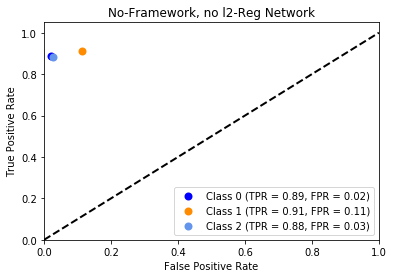

In [116]:
build_ROC_curve( one_hot_encode( tst ), est_o['target'], "No-Framework, no l2-Reg Network")

<h2> Part B </h2>
For  the part B, I train the same network, but this time I used regularization type L2 in order to limit the complexity of the network and avoid overfitting the data. I will explain again the math behind the overfitting parameter in backpropagation, however it can be skipped by you.

In [100]:
%%latex
I add a regularization term to the cost crossentropy cost function. The regularization L2 is defined as $\lambda \:||W||^2$.
This term is added to the cost as

\begin{align}
E_r = E + \lambda \:||W||^2,
\end{align}

where $E$ is the previous cost and $E_r$ is the regularized cost.

Now to definde the update on the weights on the last layer $W^L$, we have:

\begin{align}
W_{i,j}^L := W_{i,j}^L + \sigma \frac{\partial E_r}{\partial W_{i,j}},
\end{align}

and

\begin{align}
\frac{\partial E_r}{\partial W_{i,j}} &= \frac{\partial E}{\partial W_{i,j}} + \frac{\partial \lambda \:||W||^2}{\partial W_{i,j}}\\
&= \frac{\partial E}{\partial W_{i,j}} + 2\lambda \partial W_{i,j},
\end{align}

and as $\lambda$ is just a constant set by the user, I can say $2\lambda = \lambda$ and absorve the 2.

Next, I wish to the determine the update on the previous layers. As before, I determine this amount by calculating:

\begin{align}
\Delta^{L-1}_j = \frac{\partial E_r}{\partial h_j} = \frac{\partial E}{\partial h_j} + \frac{\partial \lambda \:||W||^2}{\partial h_j} = \frac{\partial E}{\partial h_j},
\end{align}

for which the direct update on the previous layers is the same as in the unregularized scenario. Nevertheless, there is an indirect update. Once the first layer is updated at the end of the epoch and taking into account the regularization whoch then is backpropagated regularly to the previous layers.


<IPython.core.display.Latex object>

The regularization update is already included in the class MLP, in the function backpropagate_calculate_dW. I now run the model again but assigning this time a value for lambda > 0.

In [106]:
# Define the network, it has 2 inputs, 20 hidden neurons on the first level,
# 20 on the second and 3 outpus
nf_network = MLP(2,20,20,3)

# Initialize random weights
nf_network.reset()

# Learn network, I select a lambda = 0.1, which is the hyper-parameter
# that controls the regularization.
learn(nf_network, samples, 0.1, 150, 0.1)


Epoch #: 0
Avg Error #: 1.102253
Epoch #: 1
Avg Error #: 1.097040
Epoch #: 2
Avg Error #: 1.090813
Epoch #: 3
Avg Error #: 1.091531
Epoch #: 4
Avg Error #: 1.086536
Epoch #: 5
Avg Error #: 1.079975
Epoch #: 6
Avg Error #: 1.077083
Epoch #: 7
Avg Error #: 1.080239
Epoch #: 8
Avg Error #: 1.074990
Epoch #: 9
Avg Error #: 1.069188
Epoch #: 10
Avg Error #: 1.074310
Epoch #: 11
Avg Error #: 1.077271
Epoch #: 12
Avg Error #: 1.062398
Epoch #: 13
Avg Error #: 1.066250
Epoch #: 14
Avg Error #: 1.057690
Epoch #: 15
Avg Error #: 1.037798
Epoch #: 16
Avg Error #: 1.031458
Epoch #: 17
Avg Error #: 1.018738
Epoch #: 18
Avg Error #: 1.013655
Epoch #: 19
Avg Error #: 0.990056
Epoch #: 20
Avg Error #: 0.968994
Epoch #: 21
Avg Error #: 0.950819
Epoch #: 22
Avg Error #: 0.946063
Epoch #: 23
Avg Error #: 0.937871
Epoch #: 24
Avg Error #: 0.928976
Epoch #: 25
Avg Error #: 0.926988
Epoch #: 26
Avg Error #: 0.926146
Epoch #: 27
Avg Error #: 0.930660
Epoch #: 28
Avg Error #: 0.881778
Epoch #: 29
Avg Error #:

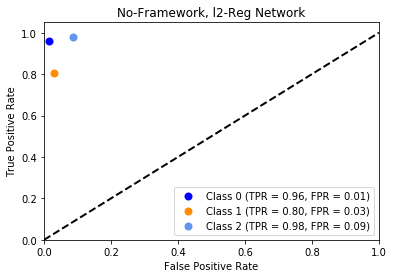

In [107]:
# Produce outputs

est_o = produce_outputs(nf_network, tst.iloc[:,:-1] , mean, std)

# Build ROC

build_ROC_curve( one_hot_encode( tst ), est_o['target'], "No-Framework, l2-Reg Network")

Although, I do not use a random seed, and thus every iteration is different, the regularized network usually yielded better results than the unregularized network for the same values of hyperparameters - wich is an expected result.

<h2> Part C </h2>
For part C, I introduce dropout regularization to the network.
<h3>Notes on dropout</h3>
Dropout regularization consists on randomly dropping nodes on a neural network in order to create a smaller network and --thus-- reducing overfitting <a href="http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf">[1]</a>. This network stochastic node dropping processed happens during training for every sample seen. After training, to generate predictions, no nodes are dropped, however the weights are scaled by a factor p, which is the probability for which a node was dropped during training.

To accomplish dropout regularization I added the methods "propagate_forward_dropout_training" and "propagate_forward_dropout_test" in the MLP class. 
<b>propagate_forward_dropout_training</b> multiplies the nodes in every layer (except the output layer) by a Bernoulli Random Variable b which can take values 1 or 0 with probability p and 1-p respectively (the input layer was also subject to dropout, however the probability is different than in the hidden layers). 
<b>propagate_forward_dropout_test</b> is used during test, which means it does not drop the nodes, but scales the weights by p and p_i for the hidden and input layers respectively. Additionally, I built a new learn and predict functions in order to handle both scenarios of this network. I add them next.

In [103]:
def learn_dropout(network, samples, p_i = 0.95, p = 0.85, epochs=100, lrate=.1, lambda_ = 0):
    ''' Function for training a dropout regularized neral network '''
    for i in range( epochs ):
        print("Epoch #: %i" % (i))
        temp_samples = np.random.permutation( samples )
        w_updates = []

        error = []

        # Produce outputs
        for sample in temp_samples:
            output = network.propagate_forward_dropout_training( sample['input'], p_i, p)
            error.append( cross_entropy_error( sample['output'], output) )

            w_update = network.backpropagate_calculate_dW( sample['output'], output, lambda_)
            w_updates.append(w_update)

        mean_dW = np.mean(w_updates, axis=0)
        network.backpropagate_update_W(mean_dW, lrate)
        print("Avg Error #: %f" % (np.mean(error)) )

def produce_outputs_dropout(network, test_set, mean, std, p_i = 0.95, p = 0.85):
    ''' Produce outputs based on a test set input on a dropout regularized neural network'''
    test_set_pd = (test_set - mean)/std
    tst = test_set_pd.as_matrix()

    outputs = np.zeros(test_set.shape[0], dtype=[('target', float, 3)])

    for i in range(test_set.shape[0]):
        # Obtain the largest output and make it 1, while the others become 0,
        # resulting in a one-hot encoded output
        outputs['target'][i][ network.propagate_forward_dropout_test(
               tst[i] , p_i, p ).argmax(axis=0) ] = 1

    return outputs

Now I train and evaluate the network

In [104]:
# Define the network, it has 2 inputs, 20 hidden neurons on the first level,
# 20 on the second and 3 outpus
nf_network = MLP(2,20,20,3)

# Initialize random weights
nf_network.reset()

# Learn network, I select a p_i = 0.9 and p = 0.5, which is the hyper-parameters
# that control the dropout probability.
learn_dropout(nf_network, samples, 0.9, 0.5, 150, 0.1)

Epoch #: 0
Avg Error #: 1.097275
Epoch #: 1
Avg Error #: 1.098459
Epoch #: 2
Avg Error #: 1.096314
Epoch #: 3
Avg Error #: 1.094910
Epoch #: 4
Avg Error #: 1.094935
Epoch #: 5
Avg Error #: 1.094820
Epoch #: 6
Avg Error #: 1.098287
Epoch #: 7
Avg Error #: 1.104347
Epoch #: 8
Avg Error #: 1.101775
Epoch #: 9
Avg Error #: 1.108277
Epoch #: 10
Avg Error #: 1.107995
Epoch #: 11
Avg Error #: 1.110682
Epoch #: 12
Avg Error #: 1.097942
Epoch #: 13
Avg Error #: 1.101191
Epoch #: 14
Avg Error #: 1.102684
Epoch #: 15
Avg Error #: 1.106770
Epoch #: 16
Avg Error #: 1.113432
Epoch #: 17
Avg Error #: 1.123248
Epoch #: 18
Avg Error #: 1.135182
Epoch #: 19
Avg Error #: 1.117586
Epoch #: 20
Avg Error #: 1.105954
Epoch #: 21
Avg Error #: 1.117432
Epoch #: 22
Avg Error #: 1.105810
Epoch #: 23
Avg Error #: 1.097175
Epoch #: 24
Avg Error #: 1.092872
Epoch #: 25
Avg Error #: 1.084968
Epoch #: 26
Avg Error #: 1.083092
Epoch #: 27
Avg Error #: 1.088435
Epoch #: 28
Avg Error #: 1.079702
Epoch #: 29
Avg Error #:

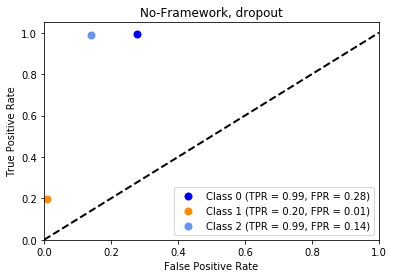

In [105]:
# Produce outputs

est_o = produce_outputs_dropout(nf_network, tst.iloc[:,:-1] , mean, std, 0.9, 0.5)

# Cleanly combine test inputs and outputs in an array

build_ROC_curve( one_hot_encode( tst ), est_o['target'], "No-Framework, dropout")

The results are not as good as with L2 regularization, however by analyzing the error in the training stage, I noticed it struggled while decreasing the error at the beggining. This means that the network perhaps needs more than th 150 iterations that I selected in order to produce a better result, which makes sense due to the complex nature of this training.

<b>Notice</b> this network is also capable of working with L2 regularization as well by adding a last parameter to the function learn_dropout(nf_network, samples, 0.9, 0.5, 150, 0.1), this last parameter will define a lambda, which I intentionally set as default to 0. It defaults to 0 because I do not see a point in using two different types of regularization at the same time, however the posibility exists in my code in case one day I want to use it.

<h2> Part D </h2>
I build now the same network (capable of L2 regularization and dropout) by using TensorFlow. First I define the class I created for the network which I called MLP_TF. I commented the code.

In [ ]:
import tensorflow as tf
import numpy as np

class MLP_TF:
    ''' Multi-layer perceptron class. '''

    def __init__(self, *args):
        ''' Initialization of the perceptron with given sizes.  '''

        self.shape = args
        
        # Network Parameters
        n_hidden_1 = self.shape[1] # 1st layer number of neurons
        n_hidden_2 = self.shape[2] # 2nd layer number of neurons
        
        n_input = self.shape[0] # number of features
        n_classes = self.shape[-1]
        
        # Store layers weight & bias
        self.weights = {
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=0.1)),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
            'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=0.1))
        }
        self.biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1], stddev=0.1)),
            'b2': tf.Variable(tf.random_normal([n_hidden_2], stddev=0.1)),
            'out': tf.Variable(tf.random_normal([n_classes], stddev=0.1))
        }
        
    def construct_and_train_model(self, samples, l_rate = 0.01, lambda_=0.01, p_i = 0.95, p = 0.5, training_epochs = 100):
        ''' Define and train a TensorFlow network with dropout '''
        
        # Insert data
        train_X = samples['input']
        train_y = samples['output']
        
        # TF Graph input
        n_input = self.shape[0] # number of features
        n_classes = self.shape[-1] # number of outputs
        
        # Define placeholders
        self.x = tf.placeholder("float", [None, n_input])
        self.y = tf.placeholder("float", [None, n_classes])
        
        # Define output used for TRAINING with dropout. Notice it does not have Softmax,
        # it is as the cost function softmax_cross_entropy_with_logits, has
        # Softmax included.
        self.yhat = self.multilayer_perceptron(self.x, self.weights, self.biases, p_i = 0.95, p = 0.5)
        
        # Define output used for TEST with dropout. Notice I added the Softmax
        self.yhat_test = self.multilayer_perceptron_test(self.x, self.weights, self.biases, p_i = 0.95, p = 0.5)
        self.predict = tf.nn.softmax(self.yhat_test)
        
        # Define loss and optimizer
        cost = tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.yhat)
        # Loss function with L2 Regularization with lambda=0.01
        regularizers = tf.nn.l2_loss(self.weights['h1']) + tf.nn.l2_loss(self.weights['h2'])

        cost = tf.reduce_mean(cost + lambda_ * regularizers)
        updates = tf.train.GradientDescentOptimizer(learning_rate=l_rate).minimize(cost)
        
        # Initializing the variables
        init = tf.global_variables_initializer()
        
        self.sess = tf.Session()
        self.sess.run(init)
    
        # Training cycle
        for epoch in range(training_epochs):
            # Notice I perform full-batch training here again

            batch_x = train_X[0: train_X.shape[0]]
            batch_y = train_y[0: train_X.shape[0]]
            
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = self.sess.run([updates, cost], feed_dict={self.x: batch_x, self.y: batch_y})

            print("Epoch #: %i" % (epoch))
            print("Cost #: %f" % (c))
                
    def multilayer_perceptron(self, x, weights, biases, p_i, p):
        ''' Network structure for training '''
        x = tf.nn.dropout(x, p_i)
        
        # Hidden layer with TANH activation
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        layer_1 = tf.nn.tanh(layer_1)
            # Add dropout
        layer_1 = tf.nn.dropout(layer_1, p)
        
        # Hidden layer with TANH activation
        layer_2 = tf.add(tf.matmul(layer_1,weights['h2']), biases['b2'])
        layer_2 = tf.nn.tanh(layer_2)
            # Add dropout
        layer_2 = tf.nn.dropout(layer_2, p)
        
        # Output layer with linear activation
        out_layer =tf.matmul(layer_2, weights['out']) + biases['out']
        
        return out_layer
    
    def multilayer_perceptron_test(self, x, weights, biases, p_i, p):
        ''' Network structure for test '''
        x = tf.nn.dropout(x, p_i)
        
        # Hidden layer with TANH activation
        layer_1 = tf.scalar_mul(p_i, tf.add(tf.matmul(x, weights['h1']), biases['b1']))
        layer_1 = tf.nn.tanh(layer_1)
        
        # Hidden layer with TANH activation
        layer_2 = tf.scalar_mul(p, tf.add(tf.matmul(layer_1,weights['h2']), biases['b2']))
        layer_2 = tf.nn.tanh(layer_2)
        
        # Output layer with linear activation
        out_layer =tf.matmul(layer_2, weights['out']) + biases['out']
        
        return out_layer

Now I train the network

In [109]:
network = MLP_TF(2,20,20,3)
network.construct_and_train_model(samples, l_rate = 0.1, lambda_=0, p_i = 0.95, p = 0.5, training_epochs = 150)

Epoch #: 0
Cost #: 1.110963
Epoch #: 1
Cost #: 1.106169
Epoch #: 2
Cost #: 1.101713
Epoch #: 3
Cost #: 1.097449
Epoch #: 4
Cost #: 1.093344
Epoch #: 5
Cost #: 1.088920
Epoch #: 6
Cost #: 1.086129
Epoch #: 7
Cost #: 1.081204
Epoch #: 8
Cost #: 1.076937
Epoch #: 9
Cost #: 1.072648
Epoch #: 10
Cost #: 1.067862
Epoch #: 11
Cost #: 1.063918
Epoch #: 12
Cost #: 1.058656
Epoch #: 13
Cost #: 1.053759
Epoch #: 14
Cost #: 1.048689
Epoch #: 15
Cost #: 1.044001
Epoch #: 16
Cost #: 1.037651
Epoch #: 17
Cost #: 1.031413
Epoch #: 18
Cost #: 1.025020
Epoch #: 19
Cost #: 1.017748
Epoch #: 20
Cost #: 1.010498
Epoch #: 21
Cost #: 1.003388
Epoch #: 22
Cost #: 0.994680
Epoch #: 23
Cost #: 0.984263
Epoch #: 24
Cost #: 0.974955
Epoch #: 25
Cost #: 0.964681
Epoch #: 26
Cost #: 0.955442
Epoch #: 27
Cost #: 0.944517
Epoch #: 28
Cost #: 0.933313
Epoch #: 29
Cost #: 0.919755
Epoch #: 30
Cost #: 0.906888
Epoch #: 31
Cost #: 0.895295
Epoch #: 32
Cost #: 0.879278
Epoch #: 33
Cost #: 0.867648
Epoch #: 34
Cost #: 0.85

Now I test the network on the test set and plot it in the ROC diagram

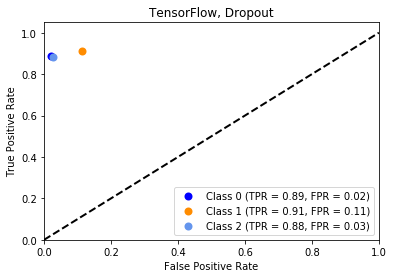

In [111]:
test_inp = tst.iloc[:,:-1]
test_inp = (test_inp - mean)/std
test_outp = tst.iloc[:,-1]

est_o = np.zeros(test_inp.shape[0], dtype=[('target', float, 3)])

for i in range(tst.shape[0]):
    batch_t_x = test_inp[i: i + 1].as_matrix()
    est_o['target'][i][ network.sess.run(network.predict,
           feed_dict={network.x: batch_t_x})[0].argmax(axis=0) ] = 1
    #t.append(network.sess.run(network.predict,
    #       feed_dict={network.x: batch_t_x}))

build_ROC_curve( one_hot_encode( tst ), est_o['target'], "TensorFlow, Dropout")

This class can also be used with L2-regularization by changing the parameter lambda_ in network.construct_and_train_model(samples, l_rate = 0.1, lambda_=0, p_i = 0.95, p = 0.5, training_epochs = 150) to a number > 0.

<h2> Final Remarks </h2>

While comparing the network I built with the TensorFlow network, I can notice a slight underperformance of my network in terms of speed and perfomance. Nevertheless, my network performed well. 